## Homework 2: Canny edge detector

The goal of the assignment is to implement a Canny edge detector. You should return the completed notebook, including answers and illustrations. 

If you are using [anaconda](https://www.anaconda.com/distribution/) you will have necessary libraries, if not, you may need to install them.

Image size: (750, 500)


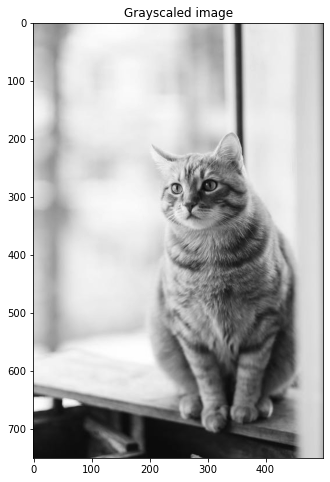

In [1]:
# Code by: Stephen Spivack 
# Date: 03-09-22
# Email: ss7726@nyu.edu

import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline 
import scipy.ndimage as ndimage #image processing library

# by default, the grayscale images are displayed with the jet colormap: use grayscale instead
plt.rcParams['image.cmap'] = 'gray'  

def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray

name = 'cat.jpeg'
img = plt.imread(name)
img = rgb2gray(img)
print('Image size:',np.shape(img))
plt.figure(figsize=(8,8)) # this allows you to control the size of the displayed image
plt.imshow(img)
plt.title('Grayscaled image')
plt.show()

## Step 1:
a- Compute a binary image corresponding to thresholding the norm of the gradient. You may use the function `ndimage.gaussian_filter` to compute the derivative of gaussian filter (see [docs](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.gaussian_filter.html)). Discuss the parameters (there are two) and their influence on the results.

In [2]:
def compute_gradient(img,sigma,threshold=0):
    '''
    Inputs: input image, sigma and threshold parameter
    Outputs: g_norm - thresholded norm of the gradient, g_theta - gradient orientation
    '''
    # Compute gradient of Gaussian kernel and convolve in both directions of image:
    Ix = ndimage.gaussian_filter(img,sigma,order=(0,1))
    Iy = ndimage.gaussian_filter(img,sigma,order=(1,0))
    
    # Compute gradient norm:
    g_norm = np.sqrt(Ix**2 + Iy**2)
    
    # Note: thresholding norm of gradient only executed for non-zero threshold values!
    if threshold != 0:
        temp_ii, temp_jj = np.where(g_norm < threshold)
        g_norm[temp_ii, temp_jj] = 0
    
    # Compute orientation of gradient:
    g_theta = np.arctan2(Iy,Ix)
    
    # Return thresholded gradient norm and angle of orientation:
    return g_norm, g_theta

After defining `compute_gradient` we ran it on our input image (cat.jpeg, grayscaled) using a non-zero, positive threshold parameter and plotted the corresponding binary image. All pixel gradient magnitudes greater than or equal to the threshold parameter are passed; everything else is set to 0.

Image size: (750, 500)
Sigma: 1
Threshold: 10


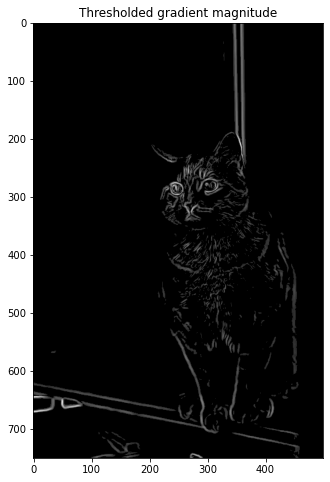

In [3]:
# Select parameter values and run function:
sigma, threshold = 1, 10
g_norm,g_theta = compute_gradient(img, sigma, threshold)
print('Image size:',np.shape(g_norm))
print('Sigma:',sigma)
print('Threshold:',threshold)

# Plot image:
plt.figure(figsize=(8,8))
plt.imshow(g_norm)
plt.title('Thresholded gradient magnitude')
plt.show()

In order to compute the remaining steps in the Canny algorithm (non-maximum suppression, double thresholding and hysteresis) we recomputed the output of `compute_gradient` without using the threshold parameter and plotted the corresponding image.

Image size: (750, 500)
Sigma: 1
Threshold: 0


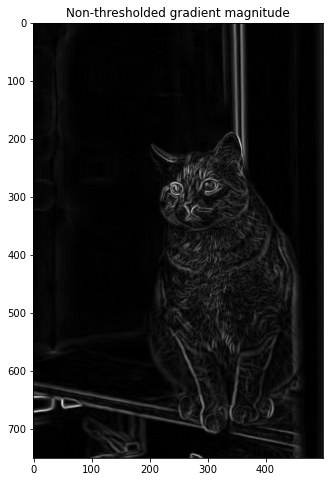

In [4]:
# Select parameter values and run function:
sigma, threshold = 1, 0
g_norm,g_theta = compute_gradient(img, sigma, threshold)
print('Image size:',np.shape(g_norm))
print('Sigma:',sigma)
print('Threshold:',threshold)

# Plot image:
plt.figure(figsize=(8,8))
plt.imshow(g_norm)
plt.title('Non-thresholded gradient magnitude')
plt.show()

To explore the effects of varying the sigma parameter, we plotted the image corresponding to sigma values [0.5,1,2,4]. From the plot we observe that sigma is largely responsible for selecting the resolution, or scale, of the image used to detect edges. Specifically, larger sigma values - which widen the size of Gaussian kernel - result in detecting more large-scale, high-level image features; smaller sigma values extract more fine-detailed, low-level image features. As such, the choice for the value of sigma presents a trade-off between localization and smoothing, or put another way, between local versus global image features.

Sigma values: [0.5 1.  2.  4. ]


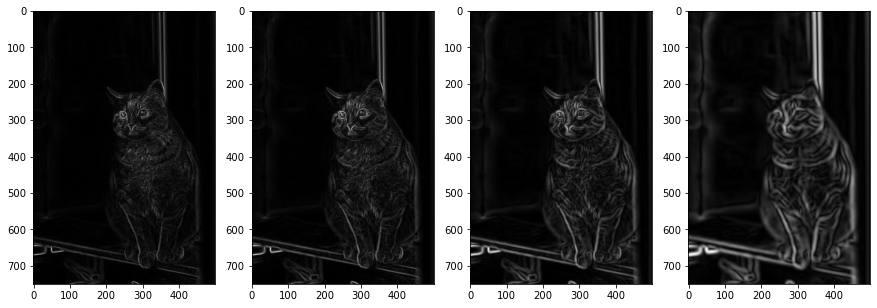

In [5]:
sigma = np.array([0.5,1,2,4])
threshold = 0
f, axarr = plt.subplots(1,len(sigma),figsize=(15,15))
for ii in range(len(sigma)):
    g_norm,g_theta = compute_gradient(img,sigma[ii],threshold)
    axarr[ii].imshow(g_norm)  
print('Sigma values:',sigma)

The threshold parameter has a similar effect as sigma in that it selects the spatial resolution, or scale, of the image. Like above, we computed images corresponding to different threshold values [2,5,10,15]. For each image we clamped the value for sigma at 1. From the plot we observe that larger threshold values result in more salient image features corresponding to larger gradient magnitudes; smaller threshold values result in more fine-detailed edges found at smaller spatial resolutions.

Threshold values: [ 2  5 10 15]


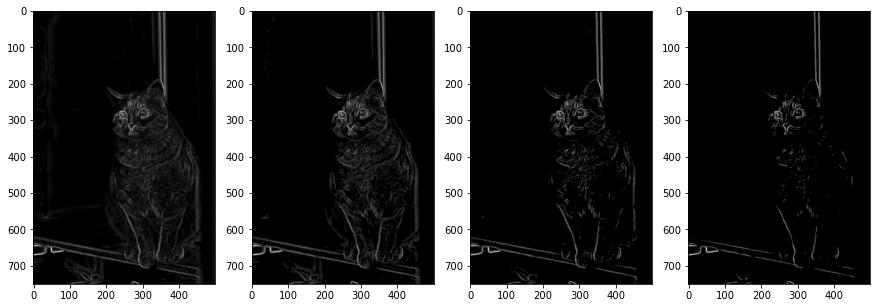

In [6]:
sigma = 1
threshold = np.array([2,5,10,15])
f, axarr = plt.subplots(1,len(threshold),figsize=(15,15))
for ii in range(len(threshold)):
    g_norm,g_theta = compute_gradient(img,sigma,threshold[ii])
    axarr[ii].imshow(g_norm)  
print('Threshold values:',threshold)

## Step 2:
b- Write a function `nms(g_norm,g_theta)` which takes as input the gradient norm and direction and outputs a binary images with value 1 only for pixels that correspond to a maximum in the direction of the gradient.

In [7]:
def non_max_suppression(g_norm, g_theta):
    '''
    Inputs: g_norm - thresholded norm of the gradient, g_theta - gradient orientation
    Outputs: Z - image processed with non-max supression
    '''
    # Convert to degrees:
    g_theta = g_theta * 180 / np.pi
    g_theta[g_theta < 0] += 180
    
    # Compute image dimensions:
    height, width = np.shape(g_norm)[0], np.shape(g_norm)[1]
    
    # Init Z as matrix of [height x width] zeros:
    Z = np.zeros((height,width))
    
    # Perform NMS algorithm:
    for ii in range(1,height-1):
        for jj in range(1, width-1):
            if (0 <= g_theta[ii,jj] < 22.5) or (157.5 <= g_theta[ii,jj] <= 180):
                temp = max(g_norm[ii,jj-1], g_norm[ii,jj+1])
            elif (22.5 <= g_theta[ii,jj] < 67.5):
                temp = max(g_norm[ii-1,jj-1], g_norm[ii+1,jj+1])
            elif (67.5 <= g_theta[ii,jj] < 112.5):
                temp = max(g_norm[ii-1,jj], g_norm[ii+1,jj])
            else:
                temp = max(g_norm[ii+1,jj-1], g_norm[ii-1,jj+1])
            if g_norm[ii,jj] >= temp:
                Z[ii,jj] = g_norm[ii,jj]
                
    # Return output image Z:      
    return Z

Image size: (750, 500)


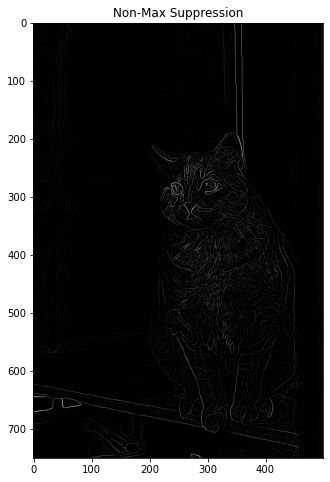

In [8]:
# Recompute the gradient magnitudes without thresholding:
sigma, threshold = 1, 0
g_norm,g_theta = compute_gradient(img, sigma, threshold)

# Run NMS function:
Z = non_max_suppression(g_norm, g_theta)
print('Image size:',np.shape(Z))

# Plot image:
plt.figure(figsize=(8,8))
plt.imshow(Z)
plt.title('Non-Max Suppression')
plt.show()

## Step 3:
c- Combine 'a' and 'b' to extract edges with a gradient norm larger than a given threshold.

In [9]:
def threshold(img,highThreshold,lowThreshold):
    '''
    Inputs: img - image processed with non-max supression, 
            highThreshold,lowThreshold - high and low threshold ratios
    Outputs: res - output image,
             weak, strong - pixel values assigned to weak and strong images
    '''
    # Compute image dimensions:
    height, width = np.shape(img)[0], np.shape(img)[1]
    
    # Init res as matrix of [height x width] zeros:
    res = np.zeros((height,width))

    # Compute indices for strong, zero and weak edges:
    strongEdge_ii, strongEdge_jj = np.where(img >= highThreshold)
    zeros_ii, zeros_jj = np.where(img < lowThreshold)
    weakEdge_ii, weakEdge_jj = np.where((img <= highThreshold) & (img >= lowThreshold))

    # Init pixel intensities for weak and strong parameters:
    weak, strong = 50, 255

    # Assign pixel intensities to strong, zero and weak indicies:
    res[strongEdge_ii, strongEdge_jj] = strong
    res[zeros_ii, zeros_jj ] = 0
    res[weakEdge_ii, weakEdge_jj] = weak

    # Return output:
    return res, weak, strong

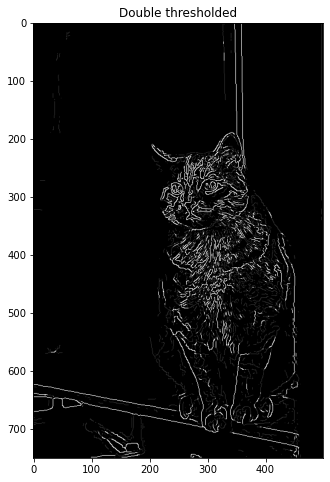

In [10]:
# Run function:
highThreshold = 10
lowThreshold = 5
res,weak,strong = threshold(Z,highThreshold,lowThreshold)

# Plot output:
plt.figure(figsize=(8,8))
plt.imshow(res)
plt.title('Double thresholded')
plt.show()

## Step 4:
d- Add the hysteresis thresholding to step 'c' to implement a function computing the Canny edges.

Here is one way to do the hysteresis thresholding. Apply step c with two thresholds $t_1 < t_2$. This yields a set of "strong pixels" (large threshold) and "weak pixels" (small threshold). Initialize a list of edge pixels by including only the set of strong pixels. For each pixel in this list, check if its neighboors are weak pixels. If they are, add them to the list of pixels to visit.

In [11]:
def hysteresis(img, weak, strong):
    '''
    Inputs: res - thresholded NMS image, 
    weak, strong - pixel values assiged to weak and strong images
    
    Outputs: img - result after hysteresis
    '''
    # Compute image dimensions:
    height, width = np.shape(img)[0], np.shape(img)[1]
    
    # Compute hysteresis algorithm:
    for ii in range(1,height-1):
        for jj in range(1, width-1):
            if (img[ii,jj] == weak):
                if strong in [img[ii+1,jj-1],img[ii+1,jj],img[ii+1,jj+1],img[ii,jj-1],
                              img[ii,jj+1],img[ii-1,jj-1],img[ii-1,jj],img[ii-1,jj+1]]:
                    img[ii,jj] = strong
                else:
                    img[ii,jj] = 0
    
    # Return output:
    return img

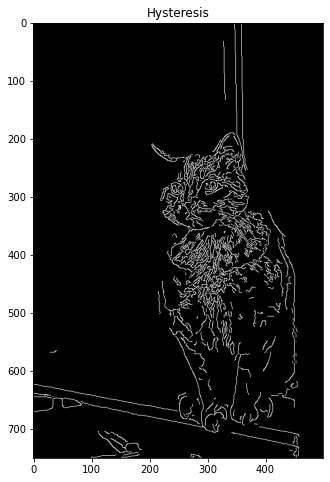

In [12]:
# Run function:
weak, strong = 50, 255
final_result = hysteresis(res,weak,strong)

# Plot output:
plt.figure(figsize=(8,8))
plt.imshow(final_result)
plt.title('Hysteresis')
plt.show()

## Step 5:
e- Run your code on at least four images of your own choosing. Use different parameters and comment on their effects.

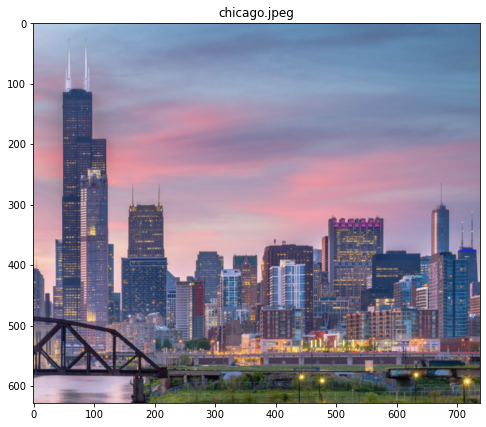

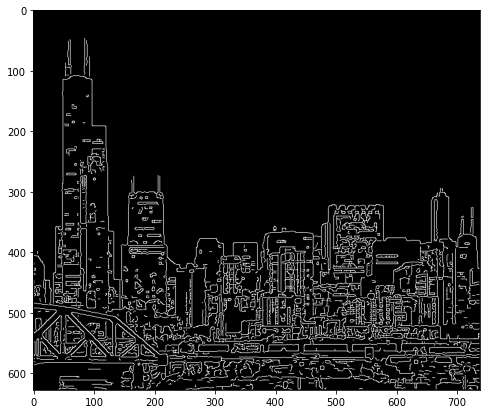

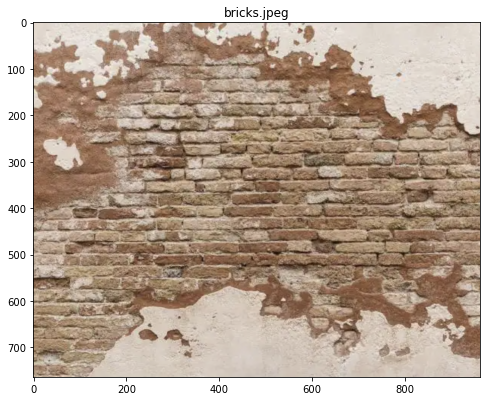

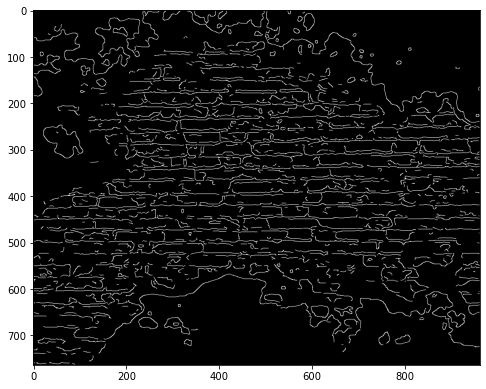

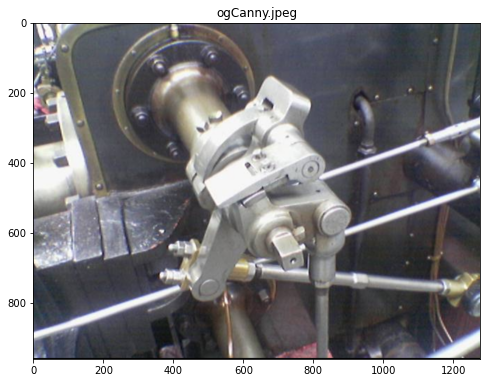

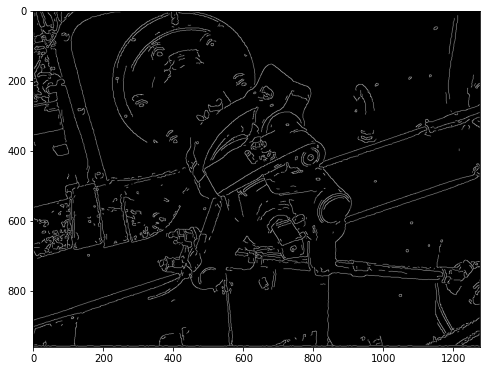

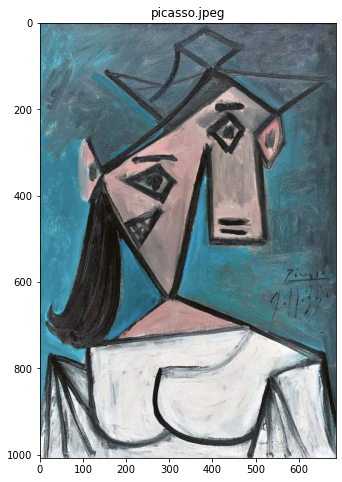

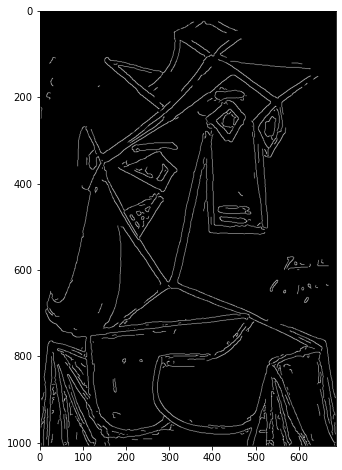

In [13]:
# Manually enter parameters for each image:
sigma=np.array([1.5,2,1,2])
lowThreshold=np.array([3,5,4,4])
highThreshold=np.array([6,10,8,8])
weak=50
strong=255

# Get file name for each image:
import os
os.chdir('images')
files = os.listdir()

# Run Canny on each image and plot the output:
for ii in range(len(files)):
    
    # Select image and grayscale it:
    img = plt.imread(files[ii])
    img = rgb2gray(img)
    
    # Step 1: compute gradient and orientation
    gradientMat, thetaMat = compute_gradient(img,sigma[ii])
    
    # Step 2: NMS
    nonMaxImg = non_max_suppression(gradientMat,thetaMat)
    
    # Step 3: double threshold
    thresholdImg, weak, strong = threshold(nonMaxImg,highThreshold[ii],lowThreshold[ii])
    
    # Step 4: hysteresis
    img_final = hysteresis(thresholdImg, weak, strong)
    
    # Plot original image:
    plt.figure(figsize=(8, 8))
    plt.imshow(plt.imread(files[ii]))
    plt.title(files[ii])
    plt.show()
    
    # Plot Canny image:
    plt.figure(figsize=(8, 8))
    plt.imshow(img_final) # canny image
    plt.show()

os.chdir('..')

Lastly, I ran the Canny edge detection algorithm on 4 different images and plotted both the original image and the Canny image. For each image I chose a different combination of sigma, low threshold and high threshold parameter values; the weak pixel and strong pixel values are clamped at 50 and 255, respectively, since they correspond to pixel intensity values in the output image and have no effect on any of the computations in the algorithm. For each image I chose the values for sigma, low threshold and high threshold based on whether I wanted to detect low-level, local features or high-level, global features.